In [0]:
# Data Processing and Cleaning
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

#Miscellaneous
from tqdm import tqdm_notebook

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train.crew[1]

"[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directing', 'gender': 2, 'id': 1201, 'job': 'Director', 'name': 'Garry Marshall', 'profile_path': '/kx77E8p5rnEmKxIhFT0qWCEMEik.jpg'}, {'credit_id': '52fe43fe9251416c75025667', 'department': 'Camera', 'gender': 2, 'id': 1214, 'job': 'Director of Photography', 'name': 'Charles Minsky', 'profile_path': None}, {'credit_id': '52fe43fe9251416c75025661', 'department': 'Sound', 'gender': 2, 'id': 4500, 'job': 'Original Music Composer', 'name': 'John Debney', 'profile_path': '/hTrlvZlDXQk49nfc2BM9sjKfJv.jpg'}, {'credit_id': '52fe43fe9251416c7502564f', 'department': 'Production', 'gender': 1, 'id': 8851, 'job': 'Producer', 'name': 'Whitney Houston', 'profile_path': '/69ouDnXnmklYPr4sMJXWKYz81AL.jpg'}, {'credit_id': '52fe43fe9251416c7502566d', 'department': 'Editing', 'gender': 0, 'id': 12970, 'job': 'Editor', 'name': 'Bruce Green', 'profile_path': '/yplxWPVgwK1b33AjvbhM9mWX2Aw.jpg'}, {'credit_id': '52fe43fe9251416c75025655', 'department

In [0]:
train['revenue'] = np.log1p(train['revenue'])


In [0]:
rf_cols = ['budget', 'original_language', 'release_date', 'runtime', 'overview', 'revenue']
rf_train = train[rf_cols].copy()
rf_cols.remove('revenue')
rf_test = test[rf_cols].copy()

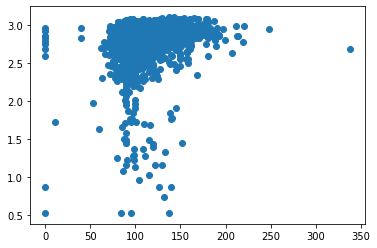

In [0]:
median_budget = rf_train[rf_train['budget'] > 0]['budget'].median()
def fill_budget(df, median_budget):
    df['budget_is_median'] = 0
    df.loc[df.budget == 0, 'budget_is_median'] = 1
    df.loc[df.budget == 0, 'budget'] = median_budget
    return df

rf_train = fill_budget(rf_train, median_budget)
rf_test = fill_budget(rf_test, median_budget)

# Plot runtime vs revenue
plt.scatter(rf_train.runtime,rf_train.revenue)

In [0]:
rf_combined = pd.concat([rf_train, rf_test], sort=False)
le = LabelEncoder()
le.fit(rf_combined['original_language'])
rf_train['original_language'] = le.transform(rf_train['original_language'])
rf_test['original_language'] = le.transform(rf_test['original_language'])

In [0]:
rf_test.loc[rf_test['status'].isnull() == True, 'status'] = 'Released'
rf_combined.loc[rf_combined['status'].isnull() == True, 'status'] = 'Released'
le = LabelEncoder()
le.fit(rf_combined['status'])
rf_train['status'] = le.transform(rf_train['status'])
rf_test['status'] = le.transform(rf_test['status'])

In [0]:
rf_train.loc[rf_train['homepage'].isnull() == True, 'homepage'] = 0
rf_train.loc[rf_train['homepage'].isnull() == False, 'homepage'] = 1

rf_test.loc[rf_test['homepage'].isnull() == True, 'homepage'] = 0
rf_test.loc[rf_test['homepage'].isnull() == False, 'homepage'] = 1


In [0]:
median_runtime = rf_train['runtime'].median()
def fill_runtime(df, median_runtime):
    df['runtime_is_median'] = 0
    df.loc[df.runtime == 0, 'runtime_is_median'] = 1
    df.loc[df.runtime.isnull() == True, 'runtime_is_median'] = 1
    df.loc[df.runtime == 0, 'runtime'] = median_runtime
    df.loc[df.runtime.isnull() == True, 'runtime'] = median_runtime
    return df

rf_train = fill_runtime(rf_train, median_runtime)
rf_test = fill_runtime(rf_test, median_runtime)

In [0]:
from datetime import timedelta, date

In [0]:
rf_test.loc[rf_test['release_date'].isnull() == True, 'release_date'] = '10/19/2001'
test.loc[test['release_date'].isnull() == True, 'release_date'] = '10/19/2001'
def add_date_features(df, col, prefix):
    df[col] = pd.to_datetime(df[col])
    future = df[col] > pd.Timestamp(year=2017,month=12,day=31)
    df.loc[future, col] -= timedelta(days=365.25*100)
    
    df[prefix+'_day_of_week'] = df[col].dt.dayofweek
    #df[prefix+'_day_of_year'] = df[col].dt.dayofyear
    df[prefix+'_month'] = df[col].dt.month
    df[prefix+'_year'] = df[col].dt.year
    df[prefix+'_day'] = df[col].dt.day
    #df[prefix+'_is_year_end'] = df[col].dt.is_year_end
    #df[prefix+'_is_year_start'] = df[col].dt.is_year_start
    #df[prefix+'_week'] = df[col].dt.week
    df[prefix+'_quarter'] = df[col].dt.quarter    
    
    df.drop(col, axis = 1, inplace = True)

    return df

rf_train = add_date_features(rf_train, 'release_date', 'release')
rf_test = add_date_features(rf_test, 'release_date', 'release')

#  Plot runtime vs revenue
plt.scatter(rf_train.runtime,rf_train.revenue)

,budget,original_language,runtime,overview,revenue,budget_is_median,runtime_is_median,release_day_of_week,release_month,release_year,release_day,release_quarter
0,14000000.0,10,93.0,"When Lou, who has become the ""father of the In...",16.326300,0,0,4,2,2015,20,1
1,40000000.0,10,113.0,Mia Thermopolis is now a college graduate and ...,18.370959,0,0,4,8,2004,6,3
2,3300000.0,10,105.0,"Under the direction of a ruthless instructor, ...",16.387512,0,0,4,10,2014,10,4
3,1200000.0,16,122.0,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,16.588099,0,0,4,3,2012,9,1
4,16000000.0,24,118.0,Marine Boy is the story of a former national s...,15.182615,1,0,3,2,2009,5,1


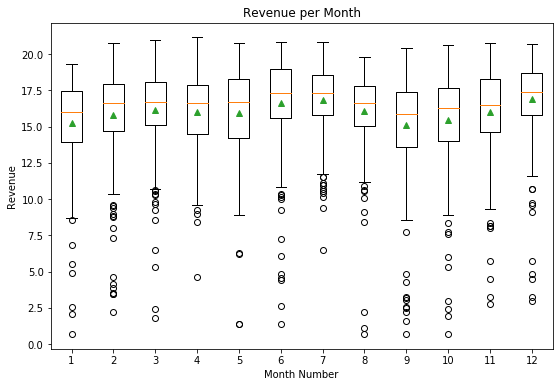

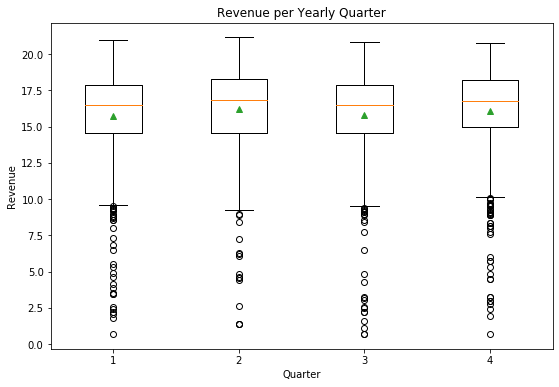

In [0]:
#plt.boxplot(rf_train.release_month, rf_train.revenue)
months_data = []
for i in range(1,13):
  months_data.append(rf_train.revenue.loc[rf_train.release_month ==i] )

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(months_data, autorange=True, showmeans=True, )
plt.title("Revenue per Month")
plt.xlabel("Month Number")
plt.ylabel("Revenue")

#l = (rf_train.revenue.loc[rf_train.release_month ==i] for i in range(1,12)  )



### Quarter
quart_data = []
for i in range(1,5):
  quart_data.append(rf_train.revenue.loc[rf_train.release_quarter ==i] )

# Create a figure instance
fig = plt.figure(2, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(quart_data, autorange=True, showmeans=True, )
plt.title("Revenue per Yearly Quarter")
plt.xlabel("Quarter")
plt.ylabel("Revenue")



rf_train.head()

In [0]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

json_cols = ['production_companies', 'cast', 'crew', 'Keywords']
for col in json_cols:
    rf_train[col] = train[col]
    rf_train[col] = rf_train[col].apply(lambda x: get_dictionary(x))
    rf_test[col] = test[col]
    rf_test[col] = rf_test[col].apply(lambda x: get_dictionary(x))



CREATE A FEATURE ON  HOW MANY POPULAR ACTORS ARE IN THE MOVIE

In [0]:
def get_num_pop_fts(feature, frame, pop_thresh):
  # Takes in a feature and a dataframe
  # Returns the input dataframe with a new column added to it "num_pop_fts"
  # Num_pop_fts tells you how many occurrences of a "popular feature" there are that movies feature
  # A popular feature is a feature that occurs more than pop_thresh times throughout the frame

  # Used to find num_pop_actors, num_pop_directors, num_pop_prodcoms, num_pop_crew for every movie

  num_pop_feats = np.zeros(np.shape(frame[feature]))
  feats_frame = []

  
## Create a matrix where each vector is a list of all actors in a movie
  for feats_dict in frame[feature]:
    feats_list = []
    if type(feats_dict) != list or len(feats_dict) < 1:
      pass
    else:
      for item in feats_dict:
        #print(item['name'])
        feats_list.append(item['name'])
    feats_frame.append(feats_list)
    #print("j", cast_dict)



  ## Find all actors that are in more movies than the popularity threshold

  # flatten column of lists of actors into one list
  flattened = [val for sublist in feats_frame for val in sublist]

  # find actors in at least 10 movies, add to new list
  popular_feats = []
  counts = Counter(flattened)

  #print(counts)
  for key, val in counts.items():
    if val >= pop_thresh:
      popular_feats.append(key)

### MODODDODOD
#  if frame is rf_train:
#    feats_frame = feats_frame[:3000]
#  elif frame is rf_test:
#    feats_frame = feats_frame[3000:]
#  else:
#    print("invalid frame entered")

  ## Create a column with the number of popular actors in each movie
  for idx in range(len(feats_frame)):
    for ft in feats_frame[idx]:
      if ft in popular_feats:
        num_pop_feats[idx] += 1
  
  column_name = "num_pop_" + str(feature)
  frame[str(column_name)] = num_pop_feats
  frame.drop(feature, axis = 1, inplace = True)

  return frame


In [0]:
from collections import Counter

get_num_pop_fts('cast', rf_train, 10)
get_num_pop_fts('crew', rf_train, 10)
get_num_pop_fts('production_companies', rf_train, 10)
get_num_pop_fts('Keywords', rf_train, 10)


get_num_pop_fts('cast', rf_test, 10)
get_num_pop_fts('crew', rf_test, 10)
get_num_pop_fts('production_companies', rf_test, 10)
get_num_pop_fts('Keywords', rf_test, 10)


rf_train
#np.shape(rf_train['cast'])

,budget,original_language,runtime,overview,revenue,budget_is_median,runtime_is_median,release_day_of_week,release_month,release_year,release_day,release_quarter,num_pop_cast,num_pop_crew,num_pop_production_companies,num_pop_Keywords
0,14000000.0,10,93.0,"When Lou, who has become the ""father of the In...",16.326300,0,0,4,2,2015,20,1,2.0,1.0,3.0,3.0
1,40000000.0,10,113.0,Mia Thermopolis is now a college graduate and ...,18.370959,0,0,4,8,2004,6,3,0.0,2.0,1.0,1.0
2,3300000.0,10,105.0,"Under the direction of a ruthless instructor, ...",16.387512,0,0,4,10,2014,10,4,1.0,3.0,1.0,4.0
3,1200000.0,16,122.0,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,16.588099,0,0,4,3,2012,9,1,0.0,0.0,0.0,2.0
4,16000000.0,24,118.0,Marine Boy is the story of a former national s...,15.182615,1,0,3,2,2009,5,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16000000.0,10,102.0,Military men Rock Reilly and Eddie Devane are ...,14.283442,1,0,4,4,1994,22,2,1.0,2.0,2.0,9.0
2996,16000000.0,35,102.0,Three girls in 1980s Stockholm decide to form ...,12.103990,1,0,3,3,2013,28,1,0.0,0.0,0.0,1.0
2997,65000000.0,10,120.0,"Samantha Caine, suburban homemaker, is the ide...",18.309266,0,0,4,10,1996,11,4,3.0,5.0,1.0,7.0
2998,42000000.0,10,90.0,Reuben Feffer is a guy who's spent his entire ...,18.962792,0,0,4,1,2004,16,1,4.0,6.0,0.0,4.0


In [0]:
"""for col in json_cols:
    # Get name of collection movie belongs to
    if col == 'belongs_to_collection':
        rf_train['collection_name'] = rf_train[col].apply(lambda row: row[0]['name'] if row != {} else '0')
        rf_test['collection_name'] = rf_test[col].apply(lambda row: row[0]['name'] if row != {} else '0')
        rf_combined = pd.concat([rf_train, rf_test], sort=False)
        le = LabelEncoder()
        le.fit(rf_combined['collection_name'])
        rf_train['collection_name'] = le.transform(rf_train['collection_name'])
        rf_test['collection_name'] = le.transform(rf_test['collection_name'])    
    
    # Size of feature
    rf_train[col] = rf_train[col].apply(lambda row: 0 if row is None else len(row))
    rf_test[col] = rf_test[col].apply(lambda row: 0 if row is None else len(row))"""

# Word count for overview
rf_train['overview_wordcount'] = rf_train['overview'].str.split().str.len()
rf_train.drop('overview', axis = 1, inplace = True)
rf_train.loc[rf_train['overview_wordcount'].isnull() == True, 'overview_wordcount'] = 0

rf_test['overview_wordcount'] = rf_test['overview'].str.split().str.len()
rf_test.drop('overview', axis = 1, inplace = True)
rf_test.loc[rf_test['overview_wordcount'].isnull() == True, 'overview_wordcount'] = 0

# Feature Interactions
rf_train['_budget_runtime_ratio'] = np.round(rf_train['budget']/rf_train['runtime'], 2)
#rf_train['_budget_year_ratio'] = np.round(rf_train['budget']/(rf_train['release_year']*rf_train['release_year']), 2)
#rf_train['_budget_revenue_ratio'] = np.round(rf_train['budget']/(rf_train['revenue']), 3)


rf_test['_budget_runtime_ratio'] = np.round(rf_test['budget']/rf_test['runtime'], 2)
#rf_test['_budget_year_ratio'] = np.round(rf_test['budget']/(rf_test['release_year']*rf_test['release_year']), 2)


In [0]:
rf_train.head()

,budget,original_language,runtime,status,homepage,revenue,budget_is_median,runtime_is_median,release_day_of_week,release_month,release_year,release_day,release_quarter,num_pop_cast,num_pop_crew,num_pop_production_companies,num_pop_Keywords,overview_wordcount,_budget_runtime_ratio
0,14000000.0,10,93.0,1,1,16.326300,0,0,4,2,2015,20,1,2.0,1.0,3.0,3.0,29.0,150537.63
1,40000000.0,10,113.0,1,1,18.370959,0,0,4,8,2004,6,3,0.0,2.0,1.0,1.0,69.0,353982.30
2,3300000.0,10,105.0,1,1,16.387512,0,0,4,10,2014,10,4,1.0,3.0,1.0,4.0,21.0,31428.57
3,1200000.0,16,122.0,1,1,16.588099,0,0,4,3,2012,9,1,0.0,0.0,0.0,2.0,106.0,9836.07
4,16000000.0,24,118.0,1,1,15.182615,1,0,3,2,2009,5,1,0.0,0.0,0.0,0.0,32.0,135593.22


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(
    rf_train.drop('revenue', axis = 1), rf_train['revenue'], 
    test_size=0.1, 
    random_state=42
)

def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

def print_rf_score(model):
    print(f'Train R2:   {model.score(X_train, y_train)}')
    print(f'Valid R2:   {model.score(X_valid, y_valid)}')
    print(f'Train RMSE: {rmse(model.predict(X_train), y_train)}')
    print(f'Valid RMSE: {rmse(model.predict(X_valid), y_valid)}')


In [0]:
rf = RandomForestRegressor(n_jobs = -1, oob_score = True, random_state = 42)
rf.fit(X_train, y_train)
print_rf_score(rf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Train R2:   0.895324666598982
Valid R2:   0.46169809224428365
Train RMSE: 0.9907437144920493
Valid RMSE: 2.2257130841524075


In [0]:
rf = RandomForestRegressor(
    n_estimators = 20, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')



Train R2:   0.9134242496825966
Valid R2:   0.4792315627926406
Train RMSE: 0.9010259133219506
Valid RMSE: 2.189165254944601
OOB Score:  0.39330261747922757


Train R2:   0.7200351761966128
Valid R2:   0.5001854233122724
Train RMSE: 1.6202830292129144
Valid RMSE: 2.144670994807949
OOB Score:  0.4572179030739101
Feature ranking:


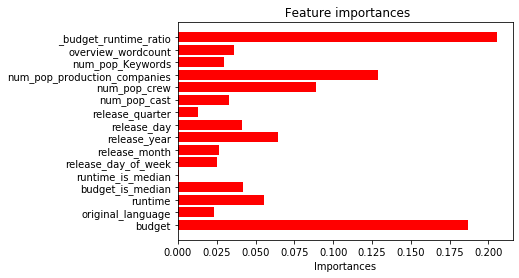

[0.18692944 0.02332903 0.05543232 0.04217292 0.00050465 0.02535892
 0.02624993 0.06425074 0.04158761 0.01306203 0.03258215 0.08907714
 0.12870141 0.02935416 0.0359359  0.20547165]


In [0]:
rf = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


# Plot the feature importances of the forest
plt.figure()
plt.title(" Feature importances")
#plt.bar(indices,importances[indices],color="r", align="center") #can also add  yerr=std[indices],
plt.barh(list(X_train), importances, color="r", align="center") #can also add  yerr=std[indices],

plt.xlabel("Importances")
plt.show()

print(importances)



In [0]:
predictions = np.expm1(rf.predict(rf_test))
submission['revenue'] = np.round(predictions)
submission.to_csv('submission_simple_rf.csv', index = False)

TypeError: ignored

In [0]:

a = list(X_train)
print(a)

for i in range(len(a)):
  print(i, a[i])
#print(list(X_train))

['budget', 'original_language', 'runtime', 'status', 'homepage', 'budget_is_median', 'runtime_is_median', 'release_day_of_week', 'release_month', 'release_year', 'release_day', 'release_quarter', 'num_pop_cast', 'num_pop_crew', 'num_pop_production_companies', 'num_pop_Keywords', 'overview_wordcount', '_budget_runtime_ratio']
0 budget
1 original_language
2 runtime
3 status
4 homepage
5 budget_is_median
6 runtime_is_median
7 release_day_of_week
8 release_month
9 release_year
10 release_day
11 release_quarter
12 num_pop_cast
13 num_pop_crew
14 num_pop_production_companies
15 num_pop_Keywords
16 overview_wordcount
17 _budget_runtime_ratio
